In [11]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def create_features(df):
    df = df.copy()

    # time features
    df["Month"] = df["Date"].dt.month
    df["DayOfWeek"] = df["Date"].dt.dayofweek

    # lag features
    for lag in [1, 7, 14, 30]:
        df[f"lag_{lag}"] = df["Units_Sold"].shift(lag)

    df["roll_mean_7"] = df["Units_Sold"].rolling(7).mean()
    df["roll_std_7"] = df["Units_Sold"].rolling(7).std()

    return df.dropna()


In [31]:
df = pd.read_csv("supply_chain_dataset1.csv")
df["Date"] = pd.to_datetime(df["Date"])

sku = df["SKU_ID"].unique()[0]
df = df[df["SKU_ID"] == sku].sort_values("Date")

df_feat = create_features(df)

# target
y = df_feat["Units_Sold"]

# select features
X = df_feat[
    [
        "lag_1", "lag_7", "lag_14", "lag_30",
        "roll_mean_7", "roll_std_7",
        "Month", "DayOfWeek",
        "Supplier_Lead_Time_Days",
        "Promotion_Flag",
        "Warehouse_ID", "Supplier_ID", "Region"
    ]
]



In [32]:
X = pd.get_dummies(
    X,
    columns=["Warehouse_ID", "Supplier_ID", "Region"],
    drop_first=True
)


In [33]:
split = len(X) - 60

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]
dates_test = df_feat["Date"].iloc[split:]



In [34]:


model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror"
)

model.fit(X_train, y_train)

pred = model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")


MAE  : 3.64
RMSE : 4.46


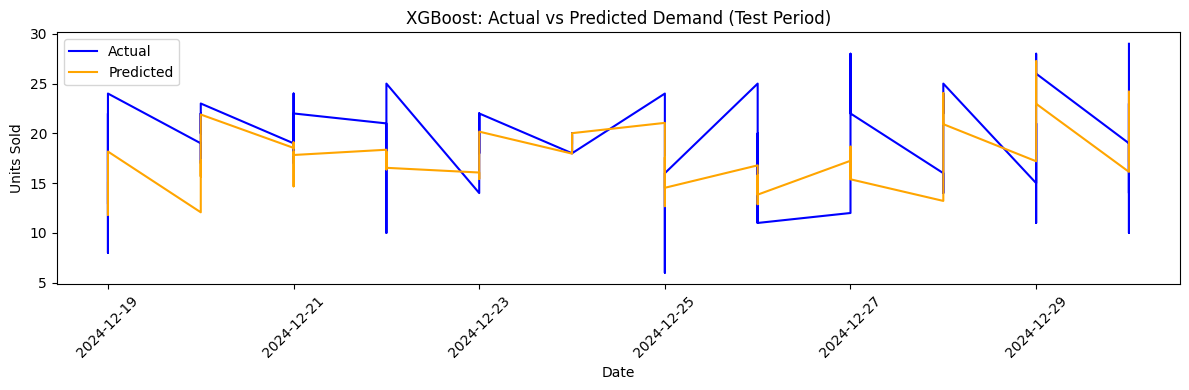

In [35]:
plt.figure(figsize=(12,4))
plt.plot(dates_test, y_test.values, label="Actual", color="blue")
plt.plot(dates_test, pred, label="Predicted", color="orange")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.title("XGBoost: Actual vs Predicted Demand (Test Period)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


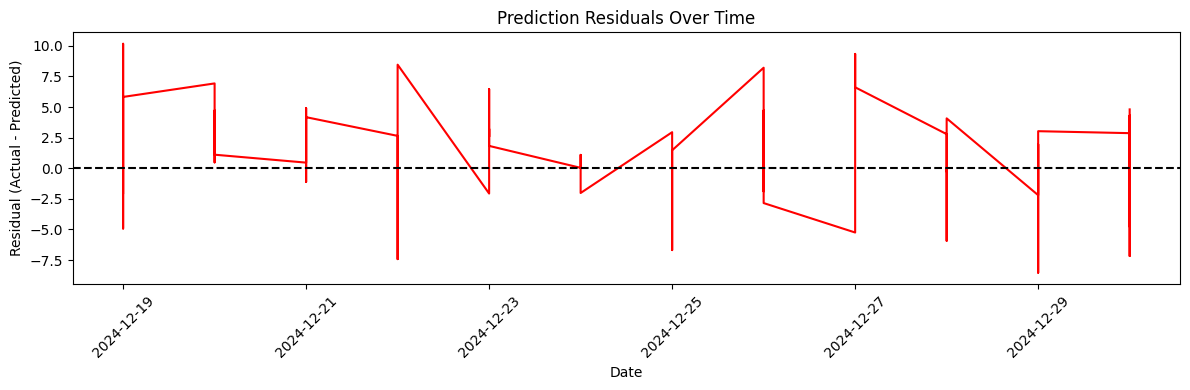

In [36]:
residuals = y_test.values - pred

plt.figure(figsize=(12,4))
plt.plot(dates_test, residuals, color="red")
plt.axhline(0, linestyle="--", color="black")
plt.xlabel("Date")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Prediction Residuals Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


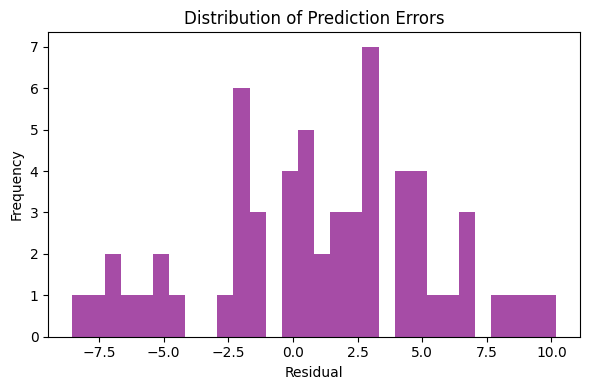

In [37]:
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, color="purple", alpha=0.7)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.tight_layout()
plt.show()


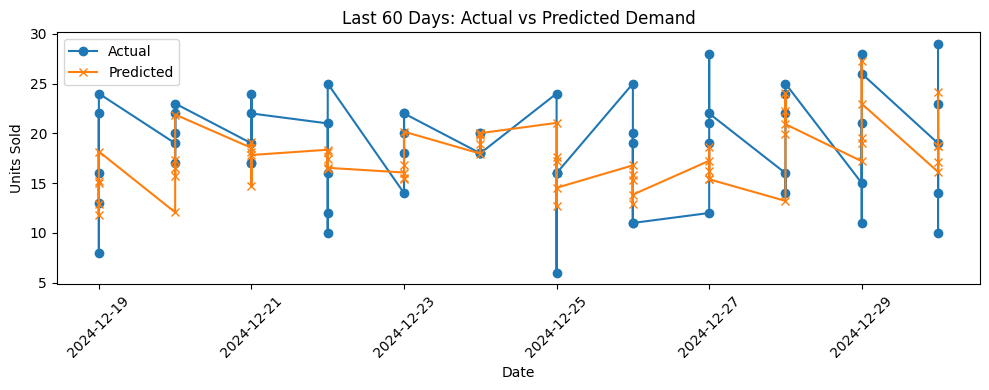

In [38]:
plt.figure(figsize=(10,4))
plt.plot(dates_test[-60:], y_test.values[-60:], label="Actual", marker="o")
plt.plot(dates_test[-60:], pred[-60:], label="Predicted", marker="x")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.title("Last 60 Days: Actual vs Predicted Demand")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


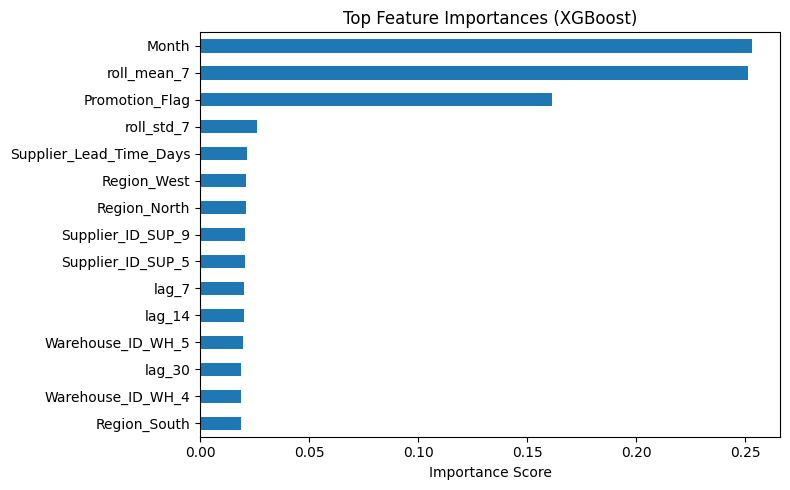

In [39]:


importance = pd.Series(
    model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(8,5))
importance.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()
